In [1]:
using Catalyst, MomentClosure, Latexify

rn = @reaction_network begin
  (c₁/Ω^2), 2X + Y → 3X
  (c₂*(1+0.5*sin(ω*(t<τ)*t))), X → Y
  (c₃*Ω, c₄), 0 ↔ X
end c₁ c₂ c₃ c₄ Ω ω τ

raw_eqs = generate_raw_moment_eqs(rn, 2, combinatoric_ratelaw=false)
latexify(raw_eqs)

"\\begin{align*}\n\\frac{d\\mu{_{10}}}{dt} =& c{_3} \\Omega + \\frac{c{_1} \\mu{_{21}}}{\\Omega^{2}} + \\frac{\\left(  - c{_1} \\right) \\mu{_{11}}}{\\Omega^{2}} - c{_2} \\mu{_{10}} - c{_4} \\mu{_{10}} - 0.5 c{_2} \\mu{_{10}} \\sin\\left( t \\omega \\left( t < \\tau \\right) \\right) \\\\\n\\frac{" ⋯ 1444 bytes ⋯ "ega^{2}} + \\frac{2 c{_1} \\mu{_{12}}}{\\Omega^{2}} + \\frac{-2 c{_1} \\mu{_{22}}}{\\Omega^{2}} + 2 c{_2} \\mu{_{11}} + c{_2} \\mu{_{11}} \\sin\\left( t \\omega \\left( t < \\tau \\right) \\right) + 0.5 c{_2} \\mu{_{10}} \\sin\\left( t \\omega \\left( t < \\tau \\right) \\right)\n\\end{align*}\n"

In [2]:
#println(latexify(raw_eqs))

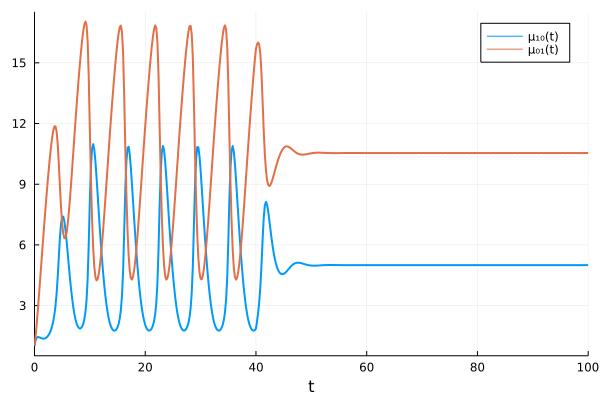

In [3]:
using OrdinaryDiffEq, Plots

closed_raw_eqs = moment_closure(raw_eqs, "normal")

# parameter values [c₁, c₂, c₃, c₄, Ω, ω, τ]
p = [0.9, 2., 1., 1., 5., 1., 40.]

# initial molecule numbers of species [X, Y]
u₀ = [1., 1.]

# deterministic initial conditions
u₀map = deterministic_IC(u₀, closed_raw_eqs)

# time interval to solve one on
tspan = (0., 100.)

# convert the closed raw moment equations into a DifferentialEquations ODEProblem
oprob = ODEProblem(closed_raw_eqs, u₀map, tspan, p)

# solve using Tsit5() solver
sol = solve(oprob, Tsit5(), saveat=0.2)
plot(sol, vars=(0, [1,2]), lw=2)

In [4]:
#savefig("Brusselator_time-dependent_normal.svg")

In [5]:
using DiffEqJump

# convert ReactionSystem into JumpSystem
jsys = convert(JumpSystem, rn, combinatoric_ratelaws=false)

# Define an ODEProblem to integrate between reaction events
# note that u₀ elements must be Floats (otherwise throws an error)
f(du,u,p,t) = du .= 0
oprob = ODEProblem(f, u₀, tspan, p)

# Create a modified SSA problem that now correctly incorporates VariableRateJumps
jprob = JumpProblem(jsys, oprob, Direct());

In [6]:
# timestep at which the solution data is saved
dt = 0.2
# the corresponding time iterator (0:0.2:100 in our case)
ts = tspan[1]:dt:tspan[2]
# save data for each trajectory only at the specified timepoints (interpolating the ODESolution)
fout = (sol, i) -> (sol(ts), false)
ensembleprob  = EnsembleProblem(jprob, output_func=fout)

# simulate 10000 SSA trajectories (can get very slow...)
@time sol_SSA = solve(ensembleprob, Tsit5(), trajectories=100);

 30.961535 seconds (32.64 M allocations: 1.996 GiB, 3.68% gc time, 93.45% compilation time)


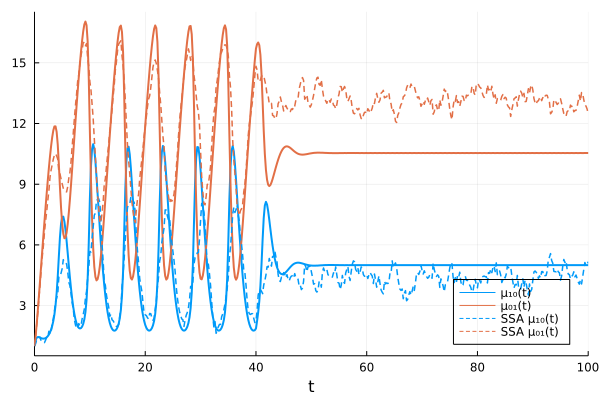

In [7]:
using DiffEqBase.EnsembleAnalysis

means_SSA = timeseries_steps_mean(sol_SSA)
plot!(means_SSA.t, [means_SSA[1,:], means_SSA[2,:]], lw=1.5, labels=["SSA μ₁₀(t)" "SSA μ₀₁(t)"], linestyle=:dash,
      linecolor=[1 2], background_color_legend=nothing, legend=:bottomright)

In [8]:
#savefig("Brusselator_time-dependent_SSA.svg")